In [1]:
## Setup

using InstantiateFromURL
activate_github("QuantEcon/QuantEconLecturePackages", tag = "v0.3.1") # activate the QuantEcon environment


using LinearAlgebra, Statistics, Compat, StaticArrays, BenchmarkTools, NLsolve, Polynomials, Plots, QuadGK, ForwardDiff # load common packages

### Exercise 1

Explore the package [StaticArrays.jl](https://github.com/JuliaArrays/StaticArrays.jl)

- Describe 2 abstract types and the hierarchy of 3 different concrete types  
- Benchmark the calculation of some simple linear algebra with a static array compared to the following for a dense arrays for `N=3` and `N=15` 

In [13]:
using Base: show_supertypes
#@show subtypes(Rational)
#@show subtypes(Real)
@show typeof(2);
show_supertypes(Int64);

typeof(2) = Int64
Int64 <: Signed <: Integer <: Real <: Number <: Any

In [20]:
@show typeof(2//3);
show_supertypes(Rational{Int64});
@show subtypes(Real);

typeof(2 // 3) = Rational{Int64}
Rational{Int64} <: Real <: Number <: Anysubtypes(Real) = Any[AbstractFloat, AbstractIrrational, Integer, Rational]


In [23]:
@show typeof([2//3, 3//2]);
show_supertypes(Array{Rational{Int64},1})
@show subtypes(AbstractArray{Rational{Int64},1});

typeof([2 // 3, 3 // 2]) = Array{Rational{Int64},1}
Array{Rational{Int64},1} <: DenseArray{Rational{Int64},1} <: AbstractArray{Rational{Int64},1} <: Anysubtypes(AbstractArray{Rational{Int64}, 1}) = Any[AbstractRange{Rational{Int64}}, LogicalIndex{Rational{Int64},A} where A<:(AbstractArray{Bool,N} where N), ReinterpretArray{Rational{Int64},1,S,A} where A<:AbstractArray{S,1} where S, ReshapedArray{Rational{Int64},1,P,MI} where MI<:Tuple{Vararg{SignedMultiplicativeInverse{Int64},N} where N} where P<:AbstractArray, AbstractRange{Rational{Int64}}, DenseArray{Rational{Int64},1}, PermutedDimsArray{Rational{Int64},1,perm,iperm,AA} where AA<:AbstractArray where iperm where perm, AbstractSparseArray{Rational{Int64},Ti,1} where Ti, TrivialView{A,Rational{Int64},1} where A, StaticArray{S,Rational{Int64},1} where S<:Tuple, SubArray{Rational{Int64},1,P,I,L} where L where I where P, GenericArray{Rational{Int64},1}]


### Exercise 1 (Solutions)

In the first instance, we just look at the concrete type of the number 2 which is Int64. This is just an integer and we show it's type hierarchy. As we can see, it's just a type of number (passing through integer and real).

In the second example, we take two thirds which is a rational. One of the  abstraact supertypes is Real which we break down and see that it contains integers and rationals, but also AbstractFloats and AbstractIrrational. These are all kinds of numbers on the real line.

In the third example, we have an array of Rationals. Now when looking the supertypes here, we find that it just abstracts to more abstract versions of Rationals without going through the supertypes of rational (which is interesting). Finally looking at the subtypes of one of these abstracts, we find a lot of different things (e.g. AbstractSparseArray), but which are all on Rationals.

In [14]:
using BenchmarkTools

BStatic=@SMatrix [2.0 4.0 8.0;16.0 32.0 64.0; 128.0 256.0 512.0]
BDense=[2 4 8; 16 32 64; 128 256 512]
CStatic=@SMatrix [1 4 9;16 25 36;49 64 81]
CDense=[1 4 9;16 25 36;49 64 81]

@btime $BStatic * $CStatic
@btime $BStatic * $CDense
@btime $BDense * $CStatic
@btime $BDense * $CDense

#@btime inv($BStatic)
#@btime inv($BDense)

@btime $BStatic^10
@btime $BDense^10

  10.784 ns (0 allocations: 0 bytes)
  49.510 ns (1 allocation: 160 bytes)
  50.430 ns (1 allocation: 160 bytes)
  51.238 ns (1 allocation: 160 bytes)
  48.640 ns (0 allocations: 0 bytes)
  196.778 ns (4 allocations: 640 bytes)


3×3 Array{Int64,2}:
  4083785382380323840   8167570764760647680  -2111602544188256256
 -4223205088376512512  -8446410176753025024   1553923720203501568
  3107847440407003136   6215694880814006272  -6015354312081539072

From the operations above, we see that Static Arrays typically do better than Dense Arrays but this seems to be driven by the allocation to memory. If only one of the elements in the operation is dense then the result is allocated and it will take the same amount of time (or nearly) as if all of the elements were dense. Moreover, there seems to be some kind of multiplying effect. It's not that allocations just add 40 ns as seems to be the case in the first example, but it's a multiplicative effect as evidenced by the second set of calculations.

In [51]:
N1=15
BStatic15=@SMatrix rand(N1,N1)
CStatic15=@SMatrix rand(N1,N1)
BDense15=rand(N1,N1);
CDense15=rand(N1,N1);

@btime $BStatic15*$CStatic15
@btime $BDense15*$CDense15

  574.954 ns (0 allocations: 0 bytes)
  1.048 μs (1 allocation: 1.98 KiB)


15×15 Array{Float64,2}:
 4.01058  5.08293  2.94423  3.45191  …  4.24327  3.33631  4.6133   3.57584
 3.95578  4.39783  3.79045  3.66242     5.11574  2.92646  4.89506  3.33249
 5.13123  4.80708  3.85557  4.07694     4.46312  3.65855  4.5671   3.44932
 3.60941  4.02607  2.86521  3.73166     3.66708  2.93916  4.03742  2.75429
 4.92822  4.83576  3.59637  3.62645     4.38286  3.38643  4.75172  4.00969
 5.32787  5.72513  4.12054  4.59779  …  5.2955   3.91901  5.19459  4.48733
 3.31629  3.48116  3.17512  2.98331     3.5827   2.86496  3.16985  2.2038 
 3.39987  4.28687  3.14473  3.37036     4.39087  2.24558  4.20119  3.21786
 3.88172  4.36401  3.91852  3.86829     4.84973  3.24114  4.49374  3.21123
 3.24178  3.66494  2.72352  2.88989     3.7771   3.08378  3.72115  2.98704
 4.84628  5.36805  4.04773  4.2863   …  4.4545   3.42961  5.06897  3.40267
 4.47902  4.7175   3.2091   3.60112     4.34518  3.52508  4.45514  3.47997
 4.79683  5.20178  4.17907  4.24037     4.86592  2.83282  4.54675  3.91677
 

Here, we see that static is only twice as fast now as the dense versions.

### Exercise 2

A key step in the calculation of the Kalman Filter is calculation of the Kalman gain, as can be seen with the following example using dense matrices from [this lecture](kalman)

Using what you learned from Exercise 1, benchmark this using Static Arrays

In [26]:
Σ = [0.4  0.3;
    0.3 0.45]
G = I
R = 0.5 * Σ

gain(Σ, G, R) = Σ * G' * inv(G * Σ * G' + R)
@btime gain($Σ, $G, $R)

ΣStatic= @SMatrix [0.4 0.3; 0.3 0.45]
RStatic = 0.5 * ΣStatic

@btime gain($ΣStatic,$G,$RStatic)
@btime gain($ΣStatic,$G,$R)
@btime gain($Σ, $G, $RStatic)

  666.575 ns (10 allocations: 1.94 KiB)
  9.411 ns (0 allocations: 0 bytes)
  10.593 ns (0 allocations: 0 bytes)
  156.455 ns (4 allocations: 448 bytes)


2×2 Array{Float64,2}:
 0.666667     1.11022e-16
 2.22045e-16  0.666667   

We see that the gains are huge from Static Arrays in this case. They're more than 67 times faster than dense arrays. Again, this has to do with the number of allocations made in the dynamic sense rather than Static. What was interesting here though is that when I used the DenseArray version of R and $\Sigma$ dense, there was almost no difference but when I made $\Sigma$ dense and R static it made 4 allocations (less thatn 10) and 156 ns. What this says is that the gains from going to Static Arrays really depends on the operations.

### Exercise 3

The [Polynomial.jl](https://github.com/JuliaMath/Polynomials.jl) provides a package for simple univariate Polynomials

Plot both `p(x)` and `p′(x)` for $ x \in [-2, 2] $

In [35]:
p = Poly([2.0, -5.0, 2.0], :x) # :x just gives a symbol for display
@show p
p′ = polyder(p) # gives the derivative of p, another polynomial
@show p(0.1), p′(0.1) # call like a function
@show roots(p); # find roots such that p(x) = 0

f(x)=2-5*x+2*x^2

p = Poly(2.0 - 5.0*x + 2.0*x^2)
(p(0.1), p′(0.1)) = (1.52, -4.6)
roots(p) = [2.0, 0.5]


f (generic function with 1 method)

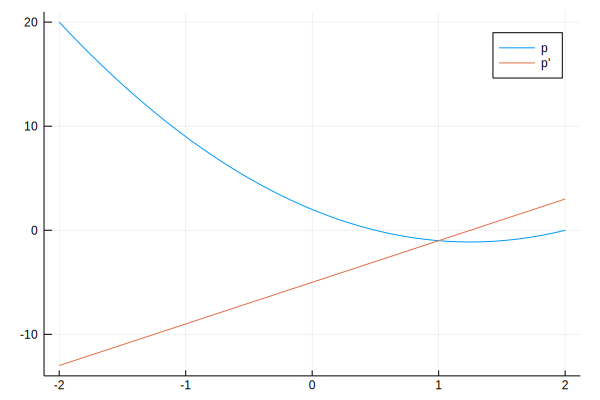

In [47]:
x=-2:.01:2
values=hcat(polyval(p,x),polyval(p′,x))
plot(x,values, label=["p", "p'"])

### Exercise 4

Using your solution to Exercise 8(a/b) in the [Julia By Example Lecture](julia_by_example) to create a specialized version of Newton’s method for Polynomials, using the `polyder` function

The signature of the function should be `newtonsmethod(p::Poly, x_0; tolerance = 1E-7, maxiter = 100)`, where the `p::Poly` ensure that this version of the function will be used anytime a polynomial is passed (i.e. dispatch)

Compare the results of this function to the built in `roots(p)`

In [11]:
function newtonsmethod(p::Poly, x_0=0;tolerance=1E-7,maxiter=100)
    x_old=x_0
    iter=0
    diff=1000
    pprime = polyder(p)
    while diff>tolerance && iter<maxiter 
        x_new=x_old-p(x_old)/pprime(x_old)
        iter=iter+1
        diff=norm(x_old-x_new)
        x_old=x_new
    end
    return(value=x_old,diff=diff,iter=iter)
end
polynomial1=Poly([2.0, -5.0, 2.0], :x)
@show newtonsmethod(polynomial1)
@show roots(polynomial1)

newtonsmethod(polynomial1) = (value = 0.5, diff = 3.4924596548080444e-10, iter = 5)
roots(polynomial1) = [2.0, 0.5]


2-element Array{Float64,1}:
 2.0
 0.5

Here we see that the newtons method was able to find one of the roots (0.5), but the built-in function was able to find both.

### Exercise 5 (Advanced)

The [trapezoidal rule](https://en.wikipedia.org/wiki/Trapezoidal_rule)  approximate an integral with

$$
\int_\underline{x}^\bar{x} f(x) \, dx \approx \sum_{n=1}^N \frac{f(x_{n-1}) + f(x_n)}{2} \Delta x_n
$$

where $ x_0 = \underline{x},\, x_N = \bar{x} $, and $ \Delta x_n \equiv x_{n-1} - x_n $

Given an `x` and a function `f`, implement a few variations of the trapezoidal rule using multiple-dispatch

- `trapezoidal(f, x)` for any `typeof(x) = AbstractArray` and `typeof(f) == AbstractArray` where `length(x) = length(f)`  
- `trapezoidal(f, x)` for any `typeof(x) = AbstractRange` and `typeof(f) == AbstractArray` where `length(x) = length(f)`
  * exploit the fact that `AbstractRange` have constant step sizes to specialize the algorithm  
- `trapezoidal(f, x̲, x̄, N)` where `typeof(f) = Function`, and the other arguments are `Real`
  * for this, build a uniform grid with `N` points on `[x̲,x̄]`, call the `f` function at those grid points, and use the existing `trapezoidal(f, x)` from the implementation  


With these,
1. Test each variation of the function with $ f(x) = x^2 $ with $ \underline{x}=0,\, \bar{x} = 1 $
2. From the analytical solution of the function, plot the error of `trapezoidal(f, x̲, x̄, N)` relative to the analytical solution for a grid of different `N` values
3. Consider trying different functions for $ f(x) $ and comparing the solutions for various `N`

When trying different functions, instead of integrating by hand consider using a high-accuracy library for numerical integration such as [QuadGK.jl](https://juliamath.github.io/QuadGK.jl/latest/)

trapezoidal(g0, x1) = 0.335
trapezoidal(h0, x2) = 0.335
trapezoidal(f0) = 0.335
(quadgk(f0, 0, 1))[1] = 0.3333333333333333


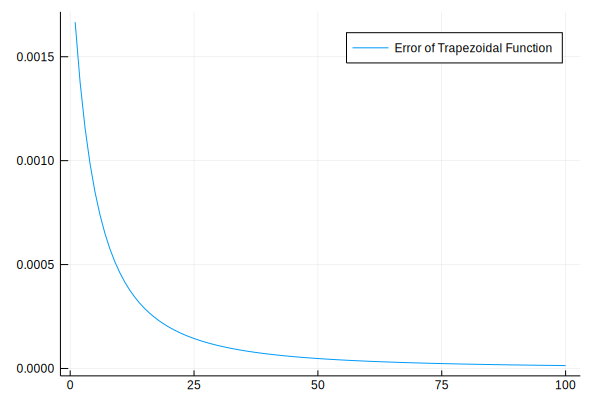

In [47]:
function trapezoidal(f::AbstractArray, x::AbstractArray)
    y=similar(x, length(x)-1)
    for i in 1:length(x)-1
        y[i]=(f[i]+f[i+1])*(x[i+1]-x[i])/2
        end
    return sum(y)
end

function trapezoidal(f::AbstractArray,x::AbstractRange)
    y=similar(x,length(x)-1)
    for i in 1:length(x)-1
        y[i]=(f[i]+f[i+1])*(x[i+1]-x[i])/2
        end
    return sum(y)
end

#function trapezoidal(f::Function;xunderline::Real=0.0,xbar::Real=1,N::Integer=11)
 #   xrange=range(xunderline,xbar,length=N)
  #  y=similar(xrange,length(xrange)-1)
   # for i in 1:length(xrange)-1
    #    y[i]=(f(xrange[i])+f(xrange[i+1]))*(xrange[i+1]-xrange[i])/2
    #end
    #return sum(y)
#end

trapezoidal(f::Function;xunderline::Real=0.0,xbar::Real=1,N::Integer=11)=trapezoidal(f.(range(xunderline,xbar,length=N)),range(xunderline,xbar,length=N))

    
    
    
x1=[0 .1 .2 .3 .4 .5 .6 .7 .8 .9 1]
x2=0:0.1:1

f0(x)=x^2
g0=f0.(x1)
h0=f0.(x2)

@show trapezoidal(g0,x1)
@show trapezoidal(h0,x2)
@show trapezoidal(f0)
@show quadgk(f0,0,1)[1]

NumberN = 100
z=zeros(NumberN)

for i in 1:NumberN
    z[i]=abs(quadgk(f0,0,1)[1]-trapezoidal(f0,0,1,i+10))
end

plot(z,label="Error of Trapezoidal Function")
    

trapezoidal(g1, x1) = 1.7197134913893146
trapezoidal(h1, x2) = 1.7197134913893146
trapezoidal(fnew) = 1.7197134913893142
(quadgk(fnew, 0, 1))[1] = 1.718281828459045


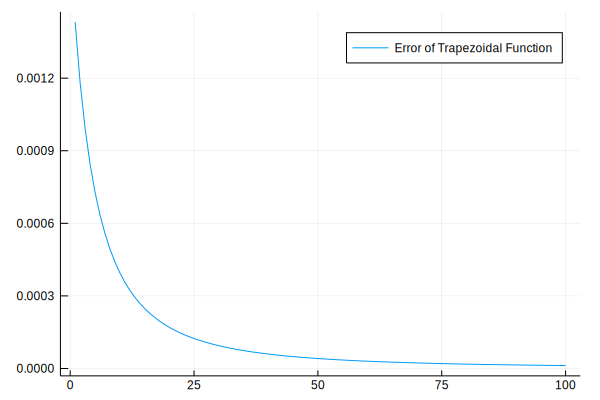

In [5]:
fnew(x)=exp(x)
g1 =fnew.(x1)
h1 =fnew.(x2)

@show trapezoidal(g1,x1)
@show trapezoidal(h1,x2)
@show trapezoidal(fnew)
@show quadgk(fnew,0,1)[1]

NumberN = 100
z1=zeros(NumberN)

for i in 1:NumberN
    z[i]=abs(quadgk(fnew,0,1)[1]-trapezoidal(fnew,0,1,i+10))
end

plot(z,label="Error of Trapezoidal Function")

### Exercise 6 (Advanced)

Take a variation of your code in Exercise 5 which implements the trapezoidal rule for the uniform grid

Use auto-differentiation to calculate the following derivative for the example functions

$$
\frac{d}{d \bar{x}}\int_\underline{x}^\bar{x} f(x) \, dx
$$

Hint: See the following code for the general pattern, and be careful to follow the [rules for generic programming](_generic_tips_tricks)

In [50]:
g_prime(x) = ForwardDiff.derivative(y -> trapezoidal(f0,xunderline=0.0,xbar=y,N=50), x)
@show g_prime(1.0)

genran(z,x)=range(0.0, length=x, stop=z)
Df(z,x) = ForwardDiff.derivative(z->trapezoidal(f0.(genran(z,x)),genran(z,x)), z)
Df(1.0,6)

g_prime(1.0) = 1.0002082465639317


1.02

Doing this exercise, I learned that when writing a function, using the similar function when creating new entries can help a lot in terms of type matching. It doesn't always matter as in Exercise 5, i.e. I was able to find the answers using zeros or fill rather than similar, but sometimes it does as in Exercise 6 when using ForwardDiff.